In [1]:
import keras
import tensorflow as tf
import numpy as np
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout,InputLayer
from tensorflow.keras import layers
from tensorflow import keras

In [2]:
train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)

targetSize = 224

train_generator = train_datagen.flow_from_directory('/nas/longleaf/home/hshugart/archive/archive/train',target_size=(targetSize, targetSize),batch_size=64,class_mode='categorical')

#Creating generator for Validation DataSet
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen.flow_from_directory('/nas/longleaf/home/hshugart/archive/archive/valid',target_size=(targetSize, targetSize),batch_size=32,class_mode='categorical')

#Creating generator for Test DataSet
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory('/nas/longleaf/home/hshugart/archive/archive/test',target_size=(targetSize, targetSize),batch_size=32,class_mode='categorical')

Found 58388 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.
Found 2000 images belonging to 400 classes.


In [3]:
base_model=keras.applications.ResNet50(include_top=False,weights="imagenet",input_shape=(targetSize,targetSize,3),pooling="avg")
base_model.trainable = False
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128,activation='relu',kernel_initializer="he_uniform"))
model.add(Dropout(0.35))
model.add(Dense(400,activation='softmax'))

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 400)               51600     
                                                                 
Total params: 23,901,584
Trainable params: 313,872
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999,epsilon=1e-07), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator,epochs=50,validation_data=val_generator)
model.save("ResnetModel")
np.save('ResnetModelHistory.npy',history.history)

Epoch 1/50
913/913 [==============================] - 515s 552ms/step - loss: 5.1204 - accuracy: 0.0797 - val_loss: 3.4026 - val_accuracy: 0.4305
Epoch 2/50
913/913 [==============================] - 506s 554ms/step - loss: 3.2101 - accuracy: 0.3053 - val_loss: 1.9192 - val_accuracy: 0.7090
Epoch 3/50
913/913 [==============================] - 505s 553ms/step - loss: 2.3379 - accuracy: 0.4509 - val_loss: 1.2751 - val_accuracy: 0.8040
Epoch 4/50
913/913 [==============================] - 506s 554ms/step - loss: 1.8681 - accuracy: 0.5445 - val_loss: 0.9363 - val_accuracy: 0.8530
Epoch 5/50
913/913 [==============================] - 515s 564ms/step - loss: 1.5699 - accuracy: 0.6077 - val_loss: 0.7321 - val_accuracy: 0.8770
Epoch 6/50
913/913 [==============================] - 504s 552ms/step - loss: 1.3655 - accuracy: 0.6552 - val_loss: 0.6082 - val_accuracy: 0.8930
Epoch 7/50
913/913 [==============================] - 510s 558ms/step - loss: 1.2099 - accuracy: 0.6907 - val_loss: 0.5176 -

In [2]:
model = keras.models.load_model("ResnetModel")
history = np.load('ResnetModelHistory.npy' ,allow_pickle=True).item()

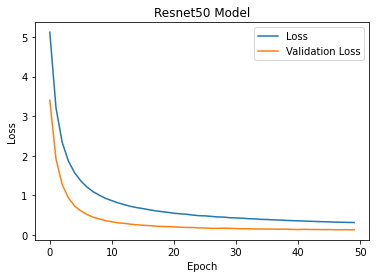

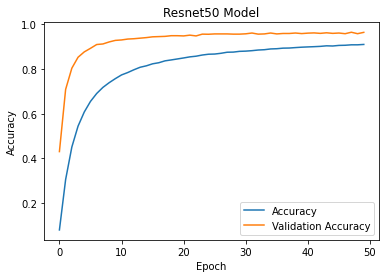

63/63 [==============================] - 8s 118ms/step - loss: 0.0939 - accuracy: 0.9745


[0.09388591349124908, 0.9745000004768372]

In [31]:
import matplotlib.pyplot as plt
#Loss
plt.plot(history['loss'],label='Loss')
plt.plot(history['val_loss'],label='Validation Loss')
plt.title("Resnet50 Model")
plt.title("Resnet50 Model")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('ResnetLossGraph.png')
plt.show()
#Accuracy
plt.plot(history['accuracy'],label='Accuracy')
plt.plot(history['val_accuracy'],label='Validation Accuracy')
plt.title("Resnet50 Model")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.savefig('ResnetAccuracyGraph.png')
plt.show()
pred_classes = model.predict(test_generator)
model.evaluate(test_generator)

In [13]:
Y_pred = model.predict(test_generator)  
y_pred = np.argmax(Y_pred, axis=1)


[ 62 260  43 ...  94 282 286]
[  0   0   0 ... 399 399 399]


In [27]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
target_names = []
for key in train_generator.class_indices:
    target_names.append(key)    
    
cm = confusion_matrix(test_generator.classes, y_pred)

plot_confusion_matrix(cm,target_names,normalize=False )


Confusion matrix, without normalization
Error in callback <function flush_figures at 0x7ff7ae6da280> (for post_execute):


KeyboardInterrupt: 